# Generative Language Model for Pokedex Entry Creation (very early draft)

Earlier this year Adam Ellis shared illustrations he made for algorithm-generated Sanrio characters. He got the character's descriptions  from a voicebox keyboard trained with the character's wikipedia bios. I found the character descriptions to be too funny, so I decided to try and generate some of my own, but using a homebrew language model rather than using voicebox. Also, I decided to use a corpus made up of the 7th Gen Pokemon Pokedex entries because it seems like it would be [funnier](http://www.dorkly.com/post/81404/20-super-dark-pokedex-entries-from-pokemon-sun-and-moon). 

I [scraped](https://docs.python-guide.org/scenarios/scrape/) the data from [Pokemon GO Hub](https://pokemongohub.net/pokemon-ultra-sun-ultra-moon/ultra-sun-moon-pokedex-entries/). The clean dataset can be found [here].

In [152]:
import pandas as pd 
raw_data = pd.read_table("raw_data", header=None)

# Cleaning the Data

In [153]:
even = raw_data.iloc[::2].reset_index(drop=True)
odd = raw_data.iloc[1::2].reset_index(drop=True)

In [154]:
pokedex = pd.concat([even,odd], axis = 1)
pokedex.columns = (["name","entry"])

In [155]:
pokedex.head()

,name,entry
0,Caterpie,Perhaps because it would like to grow up quick...
1,Metapod,Its shell is filled with a thick liquid. All o...
2,Butterfree,Its wings are covered in toxic scales. If it f...
3,Rattata,Its incisors grow continuously throughout its ...
4,Rattata(Alola),It shows no interest in anything that isn&#821...


When I was scraping the data I noticed the number of rows retrieved was even, which shouldn't be possible, since each pokemon name comes with a corresponding description, i.e.: even rows. I realized that Type Null(yes, that is a pokemon's [name](https://bulbapedia.bulbagarden.net/wiki/Type:_Null_(Pokémon)) had an aditional <p\> tag that made it jump over to the next line, and fixed it on the spot. However, two errors of this type could cancel out and give the impression that the data is correct. Let's inspect the string lengths to make sure this is not the case.

Analyzing the name lengths statistics. A description wrongly added to the names column would be an outlier in the distribution
count    468.000000
mean       8.677350
std        3.111173
min        3.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       24.000000
Name: name, dtype: float64


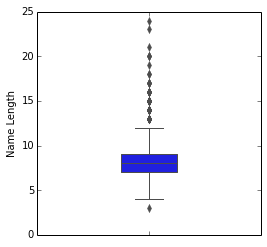

In [169]:
print "Analyzing the name lengths statistics. A description wrongly added to the names column would be an outlier in the distribution"
print pokedex_entries.name.apply(len).describe()

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pokedex["name_lengths"]  =pokedex.name.apply(len)
fig = plt.figure(figsize=(4,4))
sns.boxplot(y=pokedex.name_lengths, width = 0.25)
plt.ylabel("Name Length")

There are some outliers on both ends of the distribution. We're not too concerned with the short name (spoilers: it's Muk), and in most cases 25 characters is not enough to be a description (more on this below), but it is worth a while to take a look at the ones with more than 10 characters to see what they're about. 

In [189]:
outliers = (pokedex.name_lengths > 11) | (pokedex.name_lengths < 4)
print "Longest Name:" , pokedex.name[pokedex.name_lengths.idxmax()]
pokedex[outliers].sort_values(by = ["name_lengths"], ascending = False).head(10)

Longest Name: Magearna(Original Color)


,name,entry,name_lengths,clean_entry
461,Magearna(Original Color),This is its form from almost 500 years ago. It...,24,This is its form from almost 500 years ago. It...
339,Floette(Eternal Flower),The flower itâ€™s holding can no longer be fou...,23,The flower it's holding can no longer be found...
294,Basculin(Blue Stripe),"Even Basculin, which devours everything it can...",21,"Even Basculin, which devours everything it can..."
293,Basculin(Red Stripe),"Savage, violent Pokémon, red and blue Basculin...",20,"Savage, violent Pokémon, red and blue Basculin..."
458,Necrozma(Dawn Wings),Lunala no longer has a will of its own. Now un...,20,Lunala no longer has a will of its own. Now un...
390,Oricorio(Pa&#8217;u),It relaxes its opponents with its elegant danc...,20,It relaxes its opponents with its elegant danc...
457,Necrozma(Dusk Mane),This is its form while it is devouring the lig...,19,This is its form while it is devouring the lig...
396,Lycanroc(Midnight),It has no problem ignoring orders it doesn’t l...,18,It has no problem ignoring orders it doesn't l...
399,Wishiwashi(School),Wishiwashi assemble in this formation to face ...,18,Wishiwashi assemble in this formation to face ...
398,Whishiwashi(Solo),"They’re weak, so they move in schools. However...",17,"They're weak, so they move in schools. However..."


So, the long names are because of the pokemon name modifiers. Everything seems to be alright, except for the html codes for apostrophe \(&\#8217;). and encoding problems (â€™ instead of '). We'll fix this when we pre-process the text. 

I mentioned earlier that 25 characters is not enough to be a pokedex entry. Other than common sense, this is can be established by peeking at the distribution of entry lenghts below.

In [178]:
print pokedex_entries.entry.apply(len).describe()

count    468.000000
mean     121.935897
std       15.983267
min       70.000000
25%      111.000000
50%      124.000000
75%      134.000000
max      162.000000
Name: entry, dtype: float64


The minimum length of a pokedex entry is 70 characters.

### Pre-processing the text

In [ ]:
“fireworks of the earth.”


In [289]:
import re

apostrophe = re.compile("&#8217;|&#8216;|&#39;|â€™|’")
to_remove = re.compile("“|”|,")
def preprocess_text(txt, lower = False):    
    txt.replace("&#8211;", "-")
    txt = re.sub(to_remove, "", txt)
    txt = re.sub(apostrophe, "'", txt)
    txt = txt.lower() if lower else txt 
    return txt

In [215]:
pokedex["clean_entry"]  = pokedex.entry.apply(preprocess_text)

In [201]:
print pokedex.entry.sample(10, random_state=1)
print pokedex.clean_entry.sample(10, random_state=1)

330    When battling opponents, it sprays fire from i...
401    To attack, this Pokémon sends toxic spikes fly...
218    Castform changes to this form when rain hits i...
233    Thought to have gone extinct, Relicanth was gi...
67     Delicate equipment can malfunction in areas in...
230    Despite its appearance, it’s carnivorous. It c...
62     It&#8217;s grumpy and stubborn. If you upset i...
247    While they normally live in the sea, they can ...
159    They will cooperate to steal eggs from the nes...
372    If you try too hard to get close to it, it won...
Name: entry, dtype: object
330    When battling opponents it sprays fire from it...
401    To attack this Pokémon sends toxic spikes flyi...
218    Castform changes to this form when rain hits i...
233    Thought to have gone extinct Relicanth was giv...
67     Delicate equipment can malfunction in areas in...
230    Despite its appearance it's carnivorous. It cl...
62     It's grumpy and stubborn. If you upset it it d...
247 

In [222]:
corpus = [item.split(".") for item in pokedex["clean_entry"]]
corpus = [item.strip().split() for sublist in corpus for item in sublist if item != ""]

In [274]:
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
model = defaultdict(lambda: defaultdict(lambda: 0))

for sentence in corpus:
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1
  
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [287]:
import random
 
def generate_entry():    
    text = [None, None]
    prob = 1.0  # <- Init probability

    sentence_finished = False

    while not sentence_finished:
        r = random.random()
        accumulator = .0

        for word in model[tuple(text[-2:])].keys():
            accumulator += model[tuple(text[-2:])][word]

            if accumulator >= r:
                prob *= model[tuple(text[-2:])][word]  # <- Update the probability with the conditional probability of the new word
                text.append(word)
                break

        if text[-2:] == [None, None]:
            sentence_finished = True

    #print "Probability of text=", prob  # <- Print the probability of the text
    print ' '.join([t for t in text if t])
 
# Probability of text= 4.69753034878e-48
# DOW CHEMICAL & lt ; SFE > IN ACQUISITION TALKS Comdata Network Inc said it sold the unit , leading to the group and this would not resist a half mln barrels to 247 . 0 pct , Ivory Coast is the lowest growth rate , he said .

Some of my favorite creations:

_"Jellicent is always hanging around fancy cruise ships and tankers hoping to drag away its prey and chews them whole with its cheerful dance moves"_
Yaas, Jellicent, slay mama!

_"It doesn't just transform itself it also has the power to such an extent that it tortures its weakened prey rather than finishing them off"_
Is this Freezer we're talking about?

_"They're all hard workers who eat a lot of love from skiers and snowboarders"_
Aren't we all?

_"A clean freak that will become a malevolent deity and attack"_
Yes, this describes me perfectly.